# **Прогнозирование стоимости недвижимости. Алгоритм случайного леса.**

In [ ]:
import pandas as pd
import numpy as np
from sklearn import metrics
from datetime import datetime as dt
start = dt.now()

data = pd.read_csv('/content/sample_data/_real_estate_data.csv', index_col=0 )
pd.set_option('display.max_columns', 500)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [ ]:
data.shape

(23699, 22)

In [ ]:
# Заменяем оставшиеся пустые значения высоты потолков на медианное значение по всему датасету
data['ceiling_height'] = data.groupby(['locality_name', 'floors_total'])['ceiling_height'].apply(lambda x: x.fillna(x.median()))
data['ceiling_height'].fillna(data['ceiling_height'].median(), inplace=True)
# посчитаем количество пропущенных значений после проделанной замены
data['ceiling_height'].isnull().sum()

0

In [ ]:
# Удаляем записи, где отсутствует локация и этажность
data.dropna(subset=['locality_name'], inplace=True)
data.dropna(subset=['floors_total'], inplace=True)

In [ ]:
# Заменяем пустые значения жилой площади и площади кухни
living_ratio = data['living_area'].mean() / data['total_area'].mean()
kitchen_ratio = data['kitchen_area'].mean() / data['total_area'].mean()
data['living_area'].fillna(living_ratio * data['total_area'], inplace=True)
data['kitchen_area'].fillna(kitchen_ratio * data['total_area'], inplace=True)

In [ ]:
# Выясняем количество значений в аппартаментах. Всего аппартаменты - 50. Заменяем пропущенные значения на нет
data['is_apartment'] = data['is_apartment'].fillna(value=False)
data.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                 11475
locality_name               0
airports_nearest         5524
cityCenters_nearest      5501
parks_around3000         5500
parks_nearest           15535
ponds_around3000         5500
ponds_nearest           14529
days_exposition          3171
dtype: int64

In [ ]:
# Приводим в целочисленный тип количество балконов. Заменяем пропущенные значения на 0
data['balcony'] = data['balcony'].fillna(value=0).astype(int)

In [ ]:
data['price_for_m2']=data['last_price']/data['living_area']# Посчитали и сделали столбец со стоимостью за м2
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_for_m2
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.000000,8,False,False,False,25.000000,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,254901.960784
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,2.65,11.0,18.600000,1,False,False,False,11.000000,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,180107.526882
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,2.60,5.0,34.300000,4,False,False,False,8.300000,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,151486.880466
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.60,14.0,90.816648,9,False,False,False,27.836861,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,714626.687533
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.000000,13,False,False,False,41.000000,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,312500.000000


In [ ]:
grouped_price = data.groupby('locality_name')['price_for_m2'].transform('mean') # группируем по району
nan=data.groupby('locality_name')['price_for_m2'].mean()
nan.sort_values()

locality_name
деревня Малая Романовка              14808.362369
деревня Старополье                   18519.042595
деревня Выскатка                     18856.907895
посёлок станции Свирь                18970.699456
деревня Вахнова Кара                 20463.666177
                                        ...      
Кудрово                             206544.556584
Санкт-Петербург                     215028.546340
Зеленогорск                         218860.191692
посёлок Лисий Нос                   220052.604649
садовое товарищество Новая Ропша    250000.000000
Name: price_for_m2, Length: 364, dtype: float64

In [ ]:
data['price_for_m2'].fillna(grouped_price,inplace=True)# Заполняем пропуски медианным значением
data.dropna(subset=['price_for_m2'],inplace=True) # удаляем если остались  nan
data['price_for_m2'].isna().sum()

0

In [ ]:
grouped_airpots_nearest=data.groupby('locality_name')['airports_nearest'].transform('mean') 
data['airports_nearest'].isnull().sum()

5524

In [ ]:
data['airports_nearest'].fillna(grouped_airpots_nearest,inplace=True)#заполняем пропуски расстояния до аэропорта по среднемму значению расстояния в зависимости от района.
data['airports_nearest']=data['airports_nearest'].fillna(data['airports_nearest'].mean()) #где остались пропуски расстояния до аэропорта  заполняем просто по среднемму значению
data['airports_nearest'].isnull().sum()

0

In [ ]:
data['is_apartment']=data['is_apartment'].astype('bool') # переводим в бул
data['is_apartment'] = data['is_apartment'].apply(lambda x: 1 if x == "True" else 0) # переводим в 1 и 0
data['studio'] = data['studio'].apply(lambda x: 1 if x == "True" else 0)
data['open_plan'] = data['open_plan'].apply(lambda x: 1 if x == "True" else 0)

In [ ]:
data['cityCenters_nearest'].fillna(data.groupby('locality_name')['cityCenters_nearest'].transform('mean'),inplace=True)
data['cityCenters_nearest']=data['cityCenters_nearest'].fillna(data['cityCenters_nearest'].mean())#заполняем пропуски расстояния до центра по среднемму значению расстояния
data['cityCenters_nearest'].isnull().sum()

0

In [ ]:
data['parks_around3000']=data['parks_around3000'].fillna(data['parks_around3000'].mean())#заполняем средним
data['parks_around3000']=data['parks_around3000'].astype('int64')
data['parks_nearest']=data['parks_nearest'].fillna(data['parks_nearest'].mean())#заполняем средним
data['ponds_around3000']=data['ponds_around3000'].fillna(data['ponds_around3000'].mean())#заполняем средним
data['ponds_around3000']=data['ponds_around3000'].astype('int64')
data['ponds_nearest']=data['ponds_nearest'].fillna(data['ponds_nearest'].mean())#заполняем средним
data.isnull().sum()

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total               0
living_area                0
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area               0
balcony                    0
locality_name              0
airports_nearest           0
cityCenters_nearest        0
parks_around3000           0
parks_nearest              0
ponds_around3000           0
ponds_nearest              0
days_exposition         3171
price_for_m2               0
dtype: int64

In [ ]:
data['days_exposition']=data['days_exposition'].fillna(data['days_exposition'].median())
data['days_exposition']=data['days_exposition'].astype('int64')

In [ ]:
data['first_day_exposition']=pd.to_datetime(data['first_day_exposition'],format='%Y.%m.%dT%H:%M:%S')#перевожу в формат даты
data['first_day_exposition']=data['first_day_exposition'].dt.round('1D') # округляю до дня
data.head()
# Добавляем столбцы дня недели, месяца и года
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

In [ ]:
data = data.drop('first_day_exposition', 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [ ]:
#Вычисляем столбцы с категорийными признаками, затем заменяем их на числа
from sklearn.preprocessing import LabelEncoder
categorical_columns = data.columns[data.dtypes == 'object']
labelencoder = LabelEncoder()
for column in categorical_columns:
    data[column] = labelencoder.fit_transform(data[column])
    print(dict(enumerate(labelencoder.classes_)))

data['last_price'].describe()

{0: 'Бокситогорск', 1: 'Волосово', 2: 'Волхов', 3: 'Всеволожск', 4: 'Выборг', 5: 'Высоцк', 6: 'Гатчина', 7: 'Зеленогорск', 8: 'Ивангород', 9: 'Каменногорск', 10: 'Кингисепп', 11: 'Кириши', 12: 'Кировск', 13: 'Колпино', 14: 'Коммунар', 15: 'Красное Село', 16: 'Кронштадт', 17: 'Кудрово', 18: 'Лодейное Поле', 19: 'Ломоносов', 20: 'Луга', 21: 'Любань', 22: 'Мурино', 23: 'Никольское', 24: 'Новая Ладога', 25: 'Отрадное', 26: 'Павловск', 27: 'Петергоф', 28: 'Пикалёво', 29: 'Подпорожье', 30: 'Приморск', 31: 'Приозерск', 32: 'Пушкин', 33: 'Санкт-Петербург', 34: 'Светогорск', 35: 'Сертолово', 36: 'Сестрорецк', 37: 'Сланцы', 38: 'Сосновый Бор', 39: 'Сясьстрой', 40: 'Тихвин', 41: 'Тосно', 42: 'Шлиссельбург', 43: 'городской поселок Большая Ижора', 44: 'городской поселок Янино-1', 45: 'городской посёлок Будогощь', 46: 'городской посёлок Виллози', 47: 'городской посёлок Лесогорский', 48: 'городской посёлок Мга', 49: 'городской посёлок Назия', 50: 'городской посёлок Новоселье', 51: 'городской посёлок 

count    2.356500e+04
mean     6.540058e+06
std      1.091093e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.646000e+06
75%      6.790000e+06
max      7.630000e+08
Name: last_price, dtype: float64

In [ ]:
data.head()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_for_m2,weekday,month,year
0,20,13000000.0,108.0,3,2.70,16.0,51.000000,8,0,0,0,25.000000,0,33,18863.0,16028.0,1,482.000000,2,755.000000,95,254901.960784,3,3,2019
1,7,3350000.0,40.4,1,2.65,11.0,18.600000,1,0,0,0,11.000000,2,326,12817.0,18603.0,0,490.580448,0,518.289509,81,180107.526882,1,12,2018
2,10,5196000.0,56.0,2,2.60,5.0,34.300000,4,0,0,0,8.300000,0,33,21741.0,13933.0,1,90.000000,2,574.000000,558,151486.880466,3,8,2015
3,0,64900000.0,159.0,3,2.60,14.0,90.816648,9,0,0,0,27.836861,0,33,28098.0,6800.0,2,84.000000,3,234.000000,424,714626.687533,4,7,2015
4,2,10000000.0,100.0,2,3.03,14.0,32.000000,13,0,0,0,41.000000,0,33,31856.0,8098.0,2,112.000000,1,48.000000,121,312500.000000,1,6,2018


In [ ]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_for_m2,weekday,month,year
count,23565.000000,2.356500e+04,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.0,23565.0,23565.0,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,2.356500e+04,23565.000000,23565.000000,23565.000000
mean,9.878421,6.540058e+06,60.322824,2.070656,2.737873,10.675875,34.592277,5.878124,0.0,0.0,0.0,10.499898,0.593677,60.486909,28794.303783,14193.186076,0.468831,490.580448,0.589900,518.289509,169.203692,1.862317e+05,2.567367,6.401570,2017.371016
std,5.681156,1.091093e+07,35.657060,1.078591,1.009172,6.594823,22.373679,4.871485,0.0,0.0,0.0,6.037750,0.960660,81.593682,11057.730152,7553.339746,0.748403,199.383722,0.883966,172.146937,206.497729,1.812266e+05,1.788279,3.492948,1.037393
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,0.0,0.0,0.0,1.300000,0.000000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000,3.809375e+02,0.000000,1.000000,2014.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.550000,5.000000,19.000000,2.000000,0.0,0.0,0.0,7.000000,0.000000,33.000000,21156.000000,10935.000000,0.000000,490.580448,0.000000,518.289509,45.000000,1.267606e+05,1.000000,3.000000,2017.000000
50%,9.000000,4.646000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,0.0,0.0,0.0,9.000000,0.000000,33.000000,28794.303783,14193.186076,0.000000,490.580448,0.000000,518.289509,95.000000,1.676136e+05,3.000000,6.000000,2017.000000
75%,14.000000,6.790000e+06,69.700000,3.000000,2.750000,16.000000,42.100000,8.000000,0.0,0.0,0.0,12.000000,1.000000,33.000000,34324.000000,15247.000000,1.000000,490.580448,1.000000,518.289509,198.000000,2.200000e+05,4.000000,10.000000,2018.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,0.0,0.0,0.0,112.000000,5.000000,363.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000,2.166333e+07,6.000000,12.000000,2019.000000


In [ ]:
# Функция для подсчёта границ с учетом 1.5 размаха
def quartile_range(data, column):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    dfq = data.loc[(data[column] < q3 + 1.5*iqr) & (data[column] > q1 - 1.5*iqr), column]
    return dfq
# Столбцы с выбросами
list_features = ['last_price', 'total_area', 'kitchen_area', 'living_area', 'days_exposition', 'ceiling_height', 'rooms']
for col in list_features:
    data[col] = quartile_range(data, col)

# Возвращаем в целочисленный тип число комнат
data['rooms'] = data['rooms'].fillna(0).astype(int)

# Изучаем, есть ли выбивающиеся значения
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_for_m2,weekday,month,year
count,23565.000000,2.151900e+04,22326.000000,23565.000000,21837.000000,23565.000000,22682.000000,23565.000000,23565.0,23565.0,23565.0,22250.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,21228.000000,2.356500e+04,23565.000000,23565.000000,23565.000000
mean,9.878421,4.837115e+06,54.319704,2.013495,2.659333,10.675875,31.526984,5.878124,0.0,0.0,0.0,9.417840,0.593677,60.486909,28794.303783,14193.186076,0.468831,490.580448,0.589900,518.289509,112.794564,1.862317e+05,2.567367,6.401570,2017.371016
std,5.681156,2.215774e+06,19.331030,0.986750,0.143003,6.594823,13.752739,4.871485,0.0,0.0,0.0,3.177523,0.960660,81.593682,11057.730152,7553.339746,0.748403,199.383722,0.883966,172.146937,96.371987,1.812266e+05,1.788279,3.492948,1.037393
min,0.000000,1.219000e+04,12.000000,0.000000,2.250000,1.000000,2.000000,1.000000,0.0,0.0,0.0,1.300000,0.000000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000,3.809375e+02,0.000000,1.000000,2014.000000
25%,6.000000,3.300000e+06,39.400000,1.000000,2.550000,5.000000,18.700000,2.000000,0.0,0.0,0.0,7.000000,0.000000,33.000000,21156.000000,10935.000000,0.000000,490.580448,0.000000,518.289509,45.000000,1.267606e+05,1.000000,3.000000,2017.000000
50%,9.000000,4.400000e+06,50.000000,2.000000,2.640000,9.000000,30.000000,4.000000,0.0,0.0,0.0,9.000000,0.000000,33.000000,28794.303783,14193.186076,0.000000,490.580448,0.000000,518.289509,95.000000,1.676136e+05,3.000000,6.000000,2017.000000
75%,14.000000,6.000000e+06,65.500000,3.000000,2.750000,16.000000,40.600000,8.000000,0.0,0.0,0.0,11.000000,1.000000,33.000000,34324.000000,15247.000000,1.000000,490.580448,1.000000,518.289509,146.000000,2.200000e+05,4.000000,10.000000,2018.000000
max,50.000000,1.186686e+07,114.200000,5.000000,3.050000,60.000000,76.700000,33.000000,0.0,0.0,0.0,19.450000,5.000000,363.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,427.000000,2.166333e+07,6.000000,12.000000,2019.000000


In [ ]:
data = data.dropna() 

In [ ]:
data.shape

(18131, 25)

In [ ]:
from sklearn.model_selection import train_test_split
#Назначаем целевой переменной цену 1 кв. метра, а можно и цену всей квартиры, тогда будет y = df['price']
y = data['last_price']
#Создаем датафрейм, состоящий из признаков
features = ['total_images',	'total_area',	'rooms',	'ceiling_height',	'floors_total',	'living_area',	'floor',	'is_apartment',	'studio',	'open_plan',	'kitchen_area',	'balcony',	'locality_name',	'airports_nearest',	'cityCenters_nearest',	'parks_around3000',	'parks_nearest',	'ponds_around3000',	'ponds_nearest',	'days_exposition', 'price_for_m2',	'weekday',	'month',	'year']
X = data[features]
            
#X = data[['total_images',	'total_area',	'rooms',	'ceiling_height',	'floors_total',	'living_area',	'floor',	'is_apartment',	'studio',	'open_plan',	'kitchen_area',	'balcony',	'locality_name',	'airports_nearest',	'cityCenters_nearest',	'parks_around3000',	'parks_nearest',	'ponds_around3000',	'ponds_nearest',	'days_exposition',	'weekday',	'month',	'year']]

#Проводим случайное разбиение данных на выборки для обучения (train) и валидации (val)
train_X, val_X, train_y, val_y = train_test_split(X, y,
                                                    test_size = 0.2, 
                                                    random_state = 10)

## **Модель Random forest**

In [ ]:
#Вычисляет среднюю абсолютную процентную ошибку
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Вычисляет медианную абсолютную процентную ошибку
def median_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

#Печатает рассчитанные значения коэффициента детерминации, средней и медианной абсолютных ошибок
def print_metrics(prediction, val_y):
    val_mae = metrics.mean_absolute_error(val_y, prediction)
    median_AE = metrics.median_absolute_error(val_y, prediction)
    r2 = metrics.r2_score(val_y, prediction)
    rmse = np.sqrt(metrics.mean_squared_error(val_y, prediction))

    print('')
    print('R\u00b2: {:.2}'.format(r2))
    print('')
    print('Средняя абсолютная процентная ошибка: {:.3} %'.format(mean_absolute_percentage_error(val_y, prediction)))
    print('Медианная абсолютная процентная ошибка: {:.3} %'.format(median_absolute_percentage_error(val_y, prediction)))

    print('Средняя абсолютная ошибка: ', val_mae)
    print('Медианная абсолютная ошибка: ', median_AE)
    print('Корень из средней квадратичной ошибки: ', rmse)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

#Создаем регрессионную модель случайного леса 
rf_model = RandomForestRegressor(n_estimators=300, 
                                 #n_jobs=-1,  
                                 #bootstrap=False,
                                 #criterion='mse',
                                 #max_features=3,
                                 #random_state=1,
                                 #max_depth=55,
                                 #min_samples_split=5
                                 )

#Проводим подгонку модели на обучающей выборке 
rf_model.fit(train_X, train_y)

#Вычисляем предсказанные значения цен на основе валидационной выборки
rf_prediction = rf_model.predict(val_X).round(0)

#Вычисляем и печатаем величины ошибок при сравнении известных цен квартир из валидационной выборки с предсказанными моделью
print_metrics(rf_prediction, val_y)


R²: 1.0

Средняя абсолютная процентная ошибка: 0.878 %
Медианная абсолютная процентная ошибка: 0.371 %
Средняя абсолютная ошибка:  41249.72180865729
Медианная абсолютная ошибка:  15187.0
Корень из средней квадратичной ошибки:  140407.14465602115


In [ ]:
dat = pd.DataFrame({'Actual': val_y, 'Predicted': rf_prediction})
dat

,Actual,Predicted
3822,6000000.0,5998650.0
293,900000.0,886023.0
12243,4350000.0,4378841.0
18704,3190000.0,3182232.0
16323,5400000.0,5479140.0
...,...,...
18265,3850000.0,3792300.0
12757,3240000.0,3282869.0
22669,6800000.0,6840598.0
23636,4100000.0,3887030.0


## **важность признаков в модели Random forest**

Рейтинг важности признаков:
1. price_for_m2 (0.459437)
2. total_area (0.416033)
3. living_area (0.120731)
4. cityCenters_nearest (0.000732)
5. kitchen_area (0.000324)
6. floors_total (0.000271)
7. total_images (0.000263)
8. days_exposition (0.000260)
9. airports_nearest (0.000249)
10. floor (0.000229)
11. ceiling_height (0.000200)
12. parks_nearest (0.000192)
13. ponds_nearest (0.000175)
14. month (0.000174)
15. weekday (0.000152)
16. rooms (0.000133)
17. ponds_around3000 (0.000105)
18. locality_name (0.000095)
19. parks_around3000 (0.000093)
20. year (0.000084)
21. balcony (0.000068)
22. is_apartment (0.000000)
23. studio (0.000000)
24. open_plan (0.000000)


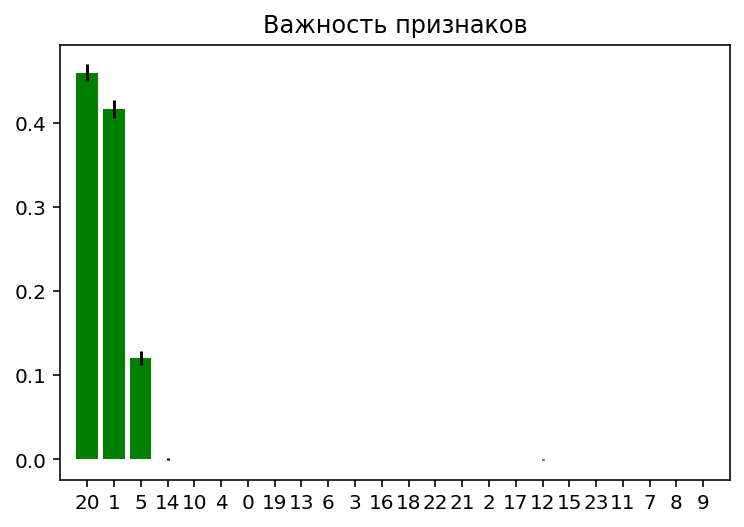

In [ ]:
#Рассчитываем важность признаков в модели Random forest
import math
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
import warnings
warnings.filterwarnings('ignore')


importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

#Печатаем рейтинг признаков
print("Рейтинг важности признаков:")
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

#Строим столбчатую диаграмму важности признаков
plt.figure()
plt.title("Важность признаков")
plt.bar(range(X.shape[1]), importances[indices], color="g", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [ ]:
running_secs = (dt.now() - start).seconds
print('Время работы алгоритма ',running_secs, 'сек')

Время работы алгоритма  40 сек


# **Алгоритм отлично прогнозирует стоимости квартир. Значимые признаки: цена за квадратный метр, общая и жилая площадь квартиры.**